MCMC chain analysis
===========

In [84]:
%matplotlib inline
import numpy as np

The first thing we need to do is open the chain file.

In [85]:
raw = np.loadtxt('chain.dat');
shape = raw.size
print("Total number of elements in chain file = {}".format(shape))
    

Total number of elements in chain file = 40000


We know that the model has two parameters, so we need to reshape the chain, and find out how many steps were taken

In [86]:
save_dim = 2
num_steps = shape/(save_dim)
print("Total number of steps in chain file = {}".format(num_steps))

Total number of steps in chain file = 20000.0


Now we need to reshape the chain into something that we can use

In [87]:
chain = raw.reshape(num_steps,save_dim)
print(chain.shape)

(20000, 2)


/Users/davidparkinson/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Now we can compute some summary statistics. Maybe we can look at the mean of the parameters

In [88]:
mean_x = np.mean(chain[:,0])
mean_y = np.mean(chain[:,1])
print("Mean (x) = {0:8.3f}, Mean (y) = {1:8.3f}".format(mean_x, mean_y))

Mean (x) =    0.121, Mean (y) =    1.450


And the standard deviations


In [89]:
var_x = np.var(chain[:,0])
var_y = np.var(chain[:,1])
print("Std dev (x) = {0:8.3f}, Std dev (y) = {1:8.3f}".format(np.sqrt(var_x), np.sqrt(var_y)))

Std dev (x) =    6.495, Std dev (y) =   13.028


The true best fit value for x and y are x=0.762 and y=-0.438556, and the errors on the two should be 0.12523 and 0.56687. What has gone wrong here?

Burn-in
------

The samples are meant to represent the distribution of probabilities for the parameters. But if the chain starts in a very low probability region, the initial chain elements will not be representative of the final distribution.

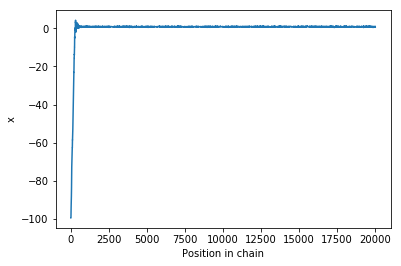

In [90]:
index = np.arange(0,num_steps)
import matplotlib.pyplot as plt
plt.plot(index,chain[:,0])
plt.xlabel('Position in chain')
plt.ylabel('x')

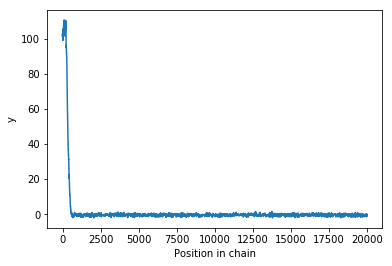

In [91]:
plt.plot(index,chain[:,1])
plt.xlabel('Position in chain')
plt.ylabel('y')

We see here that the first few hundred chain elements are composed of this 'burn-in' phase. We cut the first 1000 chain elements, and look again at the distribution.

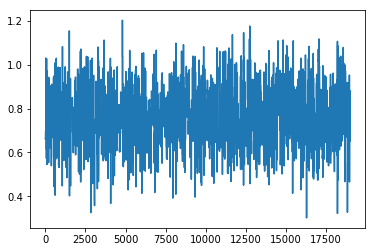

In [92]:
burn_in_index = 1000
burn_in_chain=chain[burn_in_index:,:]
burn_in_index=np.arange(0,num_steps-burn_in_index)
import matplotlib.pyplot as plt
plt.plot(burn_in_index,burn_in_chain[:,0])

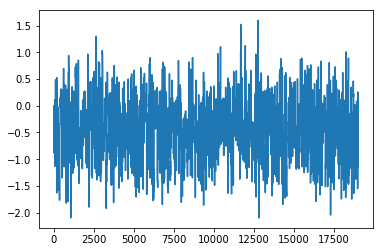

In [93]:
plt.plot(burn_in_index,burn_in_chain[:,1])

This random distribution around some mean indicates that we are now exploring the probability distribution peak. We now recompute the mean and variance, which should give a better estimate.

In [94]:
burn_in_mean_x = np.mean(burn_in_chain[:,0])
burn_in_mean_y = np.mean(burn_in_chain[:,1])
print("Mean (x) = {0:8.3f}, Mean (y) = {1:8.3f}".format(burn_in_mean_x, burn_in_mean_y))

Mean (x) =    0.767, Mean (y) =   -0.438


These values area much closer to the input model values of x = 0.762 and y = -0.438556,

In [95]:
burn_in_var_x = np.var(burn_in_chain[:,0])
burn_in_var_y = np.var(burn_in_chain[:,1])
print("Std dev (x) = {0:8.3f}, Std dev (y) = {1:8.3f}".format(np.sqrt(burn_in_var_x), np.sqrt(burn_in_var_y)))

Std dev (x) =    0.126, Std dev (y) =    0.550


These error values are much closer to the input values of errors, which are 0.12523 and 0.56687

# Probability distribution

The distribution of chain elements gives us the distribution of probabilities associated with each parameter. So we can histogram the chain 

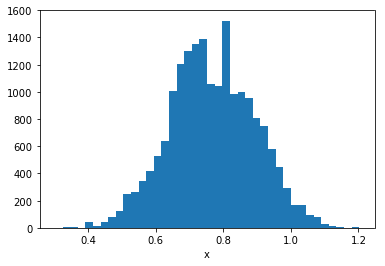

In [96]:
h_x = plt.hist(burn_in_chain[:,0],bins=40)
plt.xlabel('x')

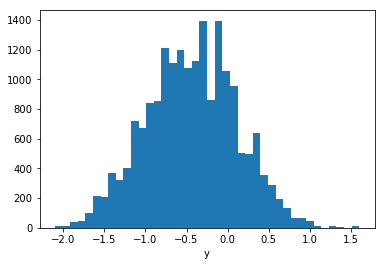

In [97]:
h_y = plt.hist(burn_in_chain[:,1],bins=40)
plt.xlabel('y')

As you can see, this histogram is slightly noisy. There are two ways to increase the accuracy of the curve, a longer chain (with more MCMC samples) or some smoothing.

In [98]:
from scipy import signal
h_new = signal.medfilt(h_x[0],5)
h_y_new = signal.medfilt(h_y[0],5)

In [99]:
print(h_new)

[  2.00000000e+00   2.00000000e+00   7.00000000e+00   9.00000000e+00
   1.00000000e+01   4.20000000e+01   4.40000000e+01   8.10000000e+01
   1.22000000e+02   2.52000000e+02   2.63000000e+02   3.44000000e+02
   4.16000000e+02   5.28000000e+02   6.40000000e+02   1.00800000e+03
   1.20300000e+03   1.29900000e+03   1.29900000e+03   1.29900000e+03
   1.35300000e+03   1.05500000e+03   1.04100000e+03   1.00200000e+03
   9.81000000e+02   9.54000000e+02   8.09000000e+02   7.46000000e+02
   5.80000000e+02   4.50000000e+02   2.94000000e+02   1.67000000e+02
   1.65000000e+02   9.20000000e+01   7.60000000e+01   2.60000000e+01
   1.30000000e+01   7.00000000e+00   4.00000000e+00   1.00000000e+00]


In [100]:
print(h_x[1])

[ 0.30170197  0.3242237   0.34674544  0.36926718  0.39178892  0.41431065
  0.43683239  0.45935413  0.48187587  0.50439761  0.52691934  0.54944108
  0.57196282  0.59448456  0.61700629  0.63952803  0.66204977  0.68457151
  0.70709324  0.72961498  0.75213672  0.77465846  0.79718019  0.81970193
  0.84222367  0.86474541  0.88726715  0.90978888  0.93231062  0.95483236
  0.9773541   0.99987583  1.02239757  1.04491931  1.06744105  1.08996278
  1.11248452  1.13500626  1.157528    1.18004973  1.20257147]


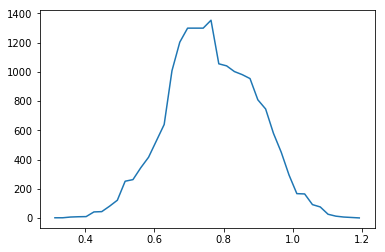

In [101]:
bins = []
len_x = len(h_x[1])
for i in range(1,len_x):
    bin_position = h_x[1][i-1]+(h_x[1][i]-h_x[1][i-1])/2.0
    bins.append(bin_position)
plt.plot(bins,h_new)

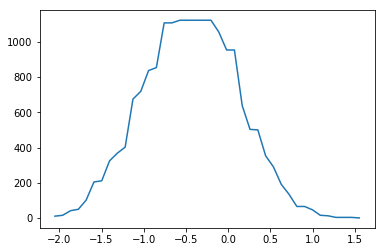

In [102]:
bins = []
len_y = len(h_y[1])
for i in range(1,len_y):
    bin_position = h_y[1][i-1]+(h_y[1][i]-h_y[1][i-1])/2.0
    bins.append(bin_position)
plt.plot(bins,h_y_new)

In [103]:
raw2 = np.loadtxt('chain_long.dat');
shape2 = raw2.size
print("Total number of elements in new chain file = {}".format(shape2))
num_steps2 = shape2/(save_dim)
print("Total number of steps in new chain file = {}".format(num_steps2))

Total number of elements in new chain file = 400000
Total number of steps in new chain file = 200000.0


Alternatively, we load the new chain.

In [104]:
chain2 = raw2.reshape(num_steps2,save_dim)

/Users/davidparkinson/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Now we need to cut off the burn-in period as before.

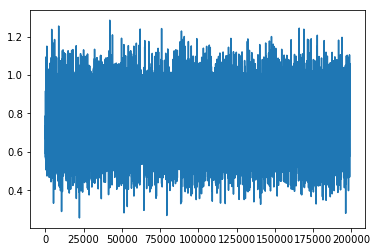

In [105]:
burn_in_cut = 1000
burn_in_chain2=chain2[burn_in_cut:,:]
burn_in_index2=np.arange(0,num_steps2-burn_in_cut)
import matplotlib.pyplot as plt
plt.plot(burn_in_index2,burn_in_chain2[:,0])

And finally plot the histograms.

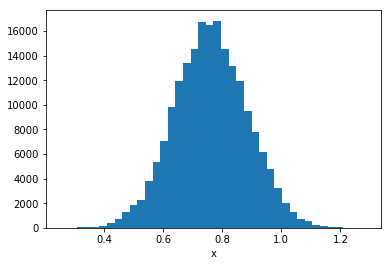

In [106]:
h_x = plt.hist(burn_in_chain2[:,0],bins=40)
plt.xlabel('x')

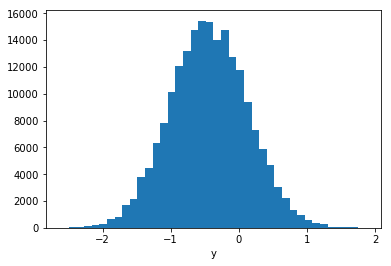

In [107]:
h_y = plt.hist(burn_in_chain2[:,1],bins=40)
plt.xlabel('y')

These histograms look a lot nicer than the previous ones.

## Convergence and Multiple Chains

Now we consider the situation where we have multiple chains, that we have run in parallel from different starting points.

In [108]:
chains = []
for ichain in range(0,4):
    raw_temp = []
    filename = 'chain_{0:1d}.dat'.format(ichain)
    raw_temp = np.loadtxt(filename);
    shape_temp = raw_temp.size
    print("Total number of elements in new chain file = {}".format(shape_temp))
    num_steps_temp = shape_temp/(save_dim)
    print("Total number of steps in new chain file = {}".format(num_steps_temp))
    chain_temp = raw_temp.reshape(num_steps_temp,save_dim)
    chains.append(chain_temp)
    
print(len(chains))

Total number of elements in new chain file = 40000
Total number of steps in new chain file = 20000.0
Total number of elements in new chain file = 40000
Total number of steps in new chain file = 20000.0
Total number of elements in new chain file = 40000
Total number of steps in new chain file = 20000.0


/Users/davidparkinson/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Total number of elements in new chain file = 40000
Total number of steps in new chain file = 20000.0
4


Now we plot them all.

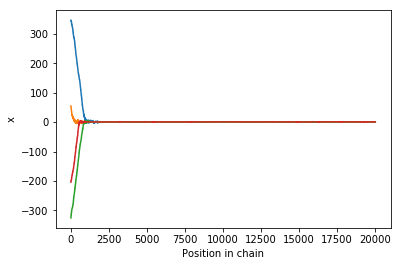

In [109]:
for ichain in range(0,4):
    n = len(chains[ichain])
    index = np.arange(0,n)
    plt.plot(index,chains[ichain][:,0])
    plt.xlabel('Position in chain')
    plt.ylabel('x')

We zoom in on the first 1000 elements.

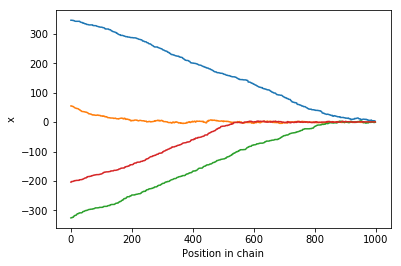

In [110]:
for ichain in range(0,4):
    index = np.arange(0,1000)
    plt.plot(index,chains[ichain][:1000,0])
    plt.xlabel('Position in chain')
    plt.ylabel('x')

As you can see, they are all burning in at different rates, depending on where they started. We will use a mor4 conservative cut of 2000, roughly 10% of the length of the individual chain (this is normally the cut I use).

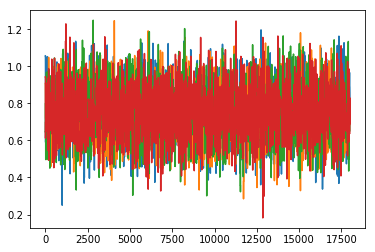

In [114]:
burn_in_chains = []
for ichain in range(0,4):
    burn_in_cut = 2000
    burn_in_chains.append(chains[ichain][burn_in_cut:,:])
    n = len(burn_in_chains[ichain])
    burn_in_index2=np.arange(0,n)
    import matplotlib.pyplot as plt
    plt.plot(burn_in_index2,burn_in_chains[ichain][:,0])

As you can see, these chains are now well mixed, and seem to be sampling the same distribution.